In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, precision_recall_curve, auc, average_precision_score
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier # Or from xgboost import XGBClassifier
import shap
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import warnings

warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

# Load datasets
try:
    fraud_data = pd.read_csv('../data/Fraud_Data.csv')
    ip_to_country = pd.read_csv('../data/IpAddress_to_Country.csv')
    credit_card_data = pd.read_csv('../data/creditcard.csv')
    print("Datasets loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading files. Make sure they are in the same directory as the notebook: {e}")

# Display basic info to confirm loading
print("\n--- Fraud_Data Overview ---")
print(fraud_data.info())
print("\n--- IpAddress_to_Country Overview ---")
print(ip_to_country.info())
print("\n--- CreditCard_Data Overview ---")
print(credit_card_data.info())

d:\Project\FraudDetection\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Datasets loaded successfully!

--- Fraud_Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB
None

--- IpAddress_to_Country Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column    

In [ ]:
print("\n--- Missing Values in Fraud_Data ---")
print(fraud_data.isnull().sum())

print("\n--- Missing Values in IpAddress_to_Country ---")
print(ip_to_country.isnull().sum())

print("\n--- Missing Values in CreditCard_Data ---")
print(credit_card_data.isnull().sum())



--- Missing Values in Fraud_Data ---
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

--- Missing Values in IpAddress_to_Country ---
lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64

--- Missing Values in CreditCard_Data ---
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [4]:
print(f"\nFraud_Data - Original rows: {len(fraud_data)}")
fraud_data.drop_duplicates(inplace=True)
print(f"Fraud_Data - Rows after dropping duplicates: {len(fraud_data)}")

print(f"\nIpAddress_to_Country - Original rows: {len(ip_to_country)}")
ip_to_country.drop_duplicates(inplace=True)
print(f"IpAddress_to_Country - Rows after dropping duplicates: {len(ip_to_country)}")

print(f"\nCreditCard_Data - Original rows: {len(credit_card_data)}")
credit_card_data.drop_duplicates(inplace=True)
print(f"CreditCard_Data - Rows after dropping duplicates: {len(credit_card_data)}")


Fraud_Data - Original rows: 151112
Fraud_Data - Rows after dropping duplicates: 151112

IpAddress_to_Country - Original rows: 138846
IpAddress_to_Country - Rows after dropping duplicates: 138846

CreditCard_Data - Original rows: 284807
CreditCard_Data - Rows after dropping duplicates: 283726


In [ ]:
# Convert timestamp columns to datetime objects in Fraud_Data
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

# Convert IP addresses to integer for merging later
fraud_data['ip_address'] = pd.to_numeric(fraud_data['ip_address'], errors='coerce')
fraud_data.dropna(subset=['ip_address'], inplace=True) # Drop rows where IP conversion failed
fraud_data['ip_address'] = fraud_data['ip_address'].astype(np.int64) # Use np.int64 for larger numbers

# IP ranges in IpAddress_to_Country are already int/float, good to go for direct comparison later.
ip_to_country['lower_bound_ip_address'] = ip_to_country['lower_bound_ip_address'].astype(np.int64)
ip_to_country['upper_bound_ip_address'] = ip_to_country['upper_bound_ip_address'].astype(np.int64)

print("\n--- Data Types after Correction in Fraud_Data ---")
print(fraud_data.info())
print("\n--- Data Types after Correction in IpAddress_to_Country ---")
print(ip_to_country.info())


--- Data Types after Correction in Fraud_Data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  int64         
 10  class           151112 non-null  int64         
dtypes: datetime64[ns](2), int64(5), object(4)
memory usage: 12.7+ MB
None

--- Data Types after Correction in IpAddress_to_Country ---
<class 'panda


--- Univariate Analysis: Fraud_Data ---
             user_id                    signup_time  \
count  151112.000000                         151112   
mean   200171.040970  2015-04-20 00:56:09.511329280   
min         2.000000            2015-01-01 00:00:42   
25%    100642.500000     2015-02-18 09:52:48.500000   
50%    199958.000000            2015-04-19 04:41:30   
75%    300054.000000  2015-06-18 14:47:22.750000128   
max    400000.000000            2015-08-18 04:40:29   
std    115369.285024                            NaN   

                       purchase_time  purchase_value            age  \
count                         151112   151112.000000  151112.000000   
mean   2015-06-16 02:56:38.759952896       36.935372      33.140704   
min              2015-01-01 00:00:44        9.000000      18.000000   
25%       2015-04-18 14:41:25.500000       22.000000      27.000000   
50%       2015-06-18 13:46:17.500000       35.000000      33.000000   
75%       2015-08-17 18:48:31.500000 

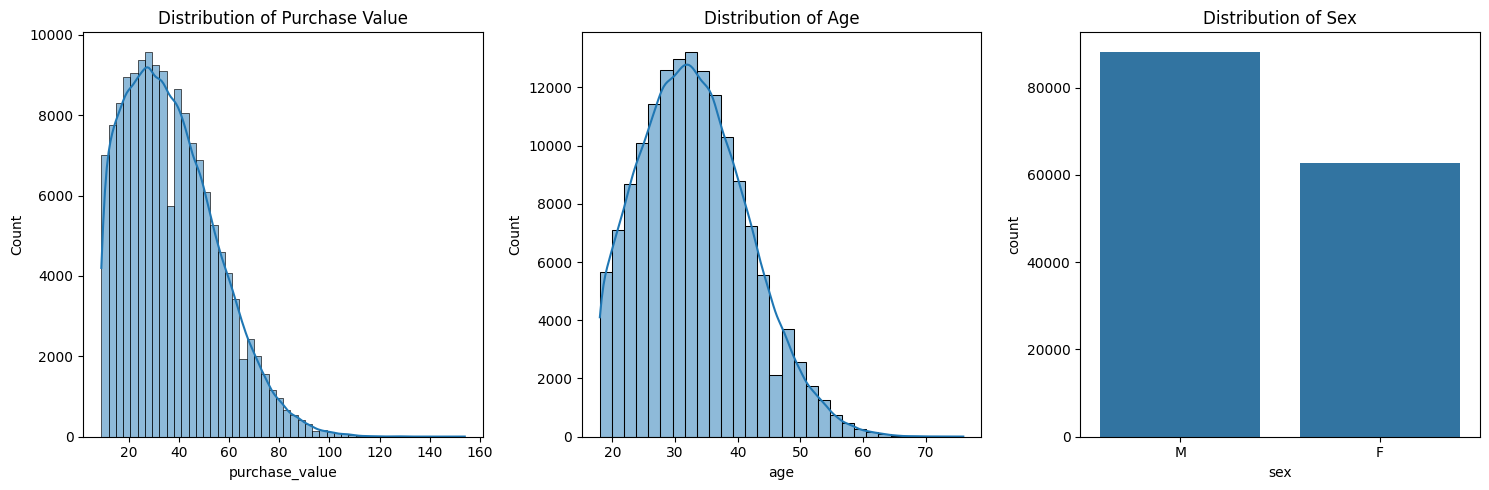

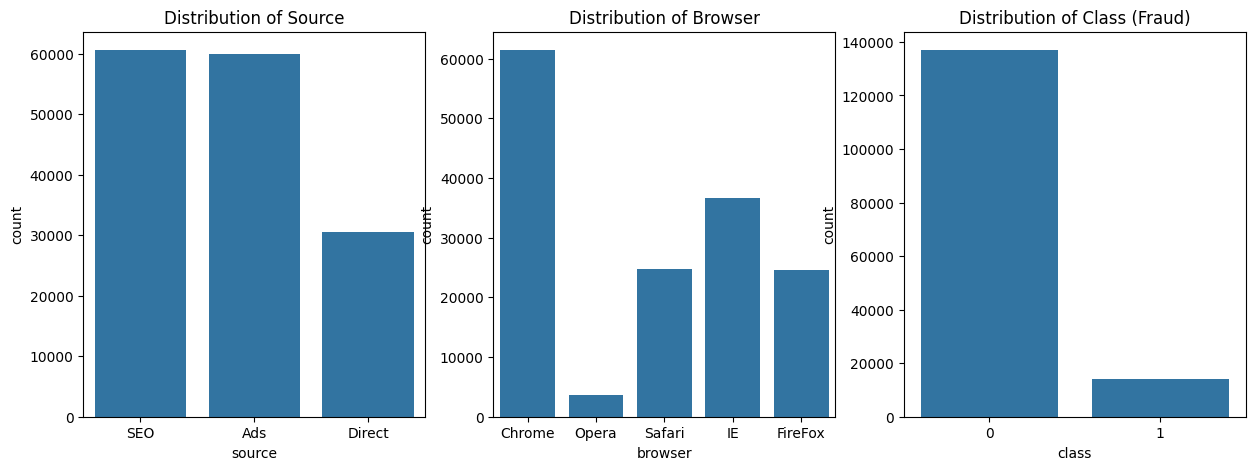


--- Univariate Analysis: CreditCard_Data ---
                Time             V1             V2             V3  \
count  283726.000000  283726.000000  283726.000000  283726.000000   
mean    94811.077600       0.005917      -0.004135       0.001613   
std     47481.047891       1.948026       1.646703       1.508682   
min         0.000000     -56.407510     -72.715728     -48.325589   
25%     54204.750000      -0.915951      -0.600321      -0.889682   
50%     84692.500000       0.020384       0.063949       0.179963   
75%    139298.000000       1.316068       0.800283       1.026960   
max    172792.000000       2.454930      22.057729       9.382558   

                  V4             V5             V6             V7  \
count  283726.000000  283726.000000  283726.000000  283726.000000   
mean       -0.002966       0.001828      -0.001139       0.001801   
std         1.414184       1.377008       1.331931       1.227664   
min        -5.683171    -113.743307     -26.160506     -

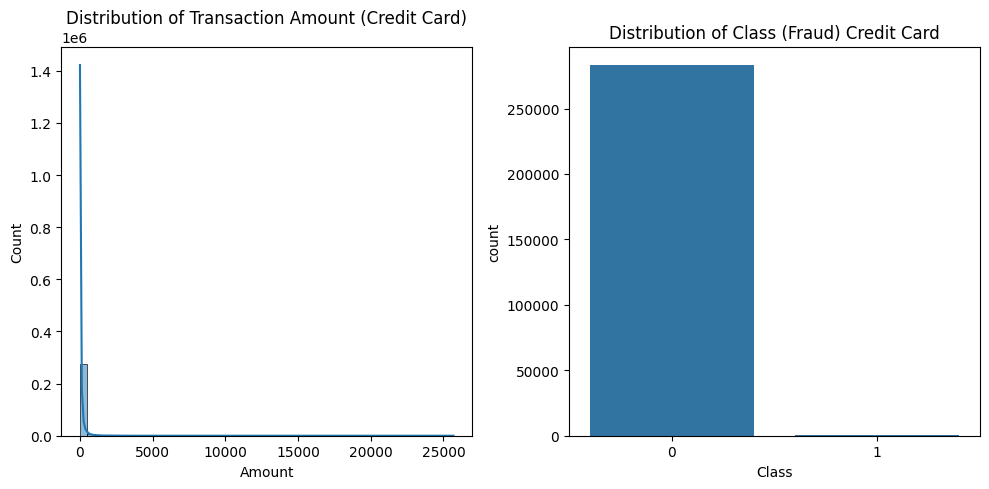

In [6]:
# Fraud_Data
print("\n--- Univariate Analysis: Fraud_Data ---")
print(fraud_data.describe())

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(fraud_data['purchase_value'], bins=50, kde=True)
plt.title('Distribution of Purchase Value')

plt.subplot(1, 3, 2)
sns.histplot(fraud_data['age'], bins=30, kde=True)
plt.title('Distribution of Age')

plt.subplot(1, 3, 3)
sns.countplot(x='sex', data=fraud_data)
plt.title('Distribution of Sex')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x='source', data=fraud_data)
plt.title('Distribution of Source')

plt.subplot(1, 3, 2)
sns.countplot(x='browser', data=fraud_data)
plt.title('Distribution of Browser')

plt.subplot(1, 3, 3)
sns.countplot(x='class', data=fraud_data)
plt.title('Distribution of Class (Fraud)')
plt.show()

# CreditCard_Data
print("\n--- Univariate Analysis: CreditCard_Data ---")
print(credit_card_data.describe())

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(credit_card_data['Amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amount (Credit Card)')

plt.subplot(1, 2, 2)
sns.countplot(x='Class', data=credit_card_data)
plt.title('Distribution of Class (Fraud) Credit Card')
plt.tight_layout()
plt.show()

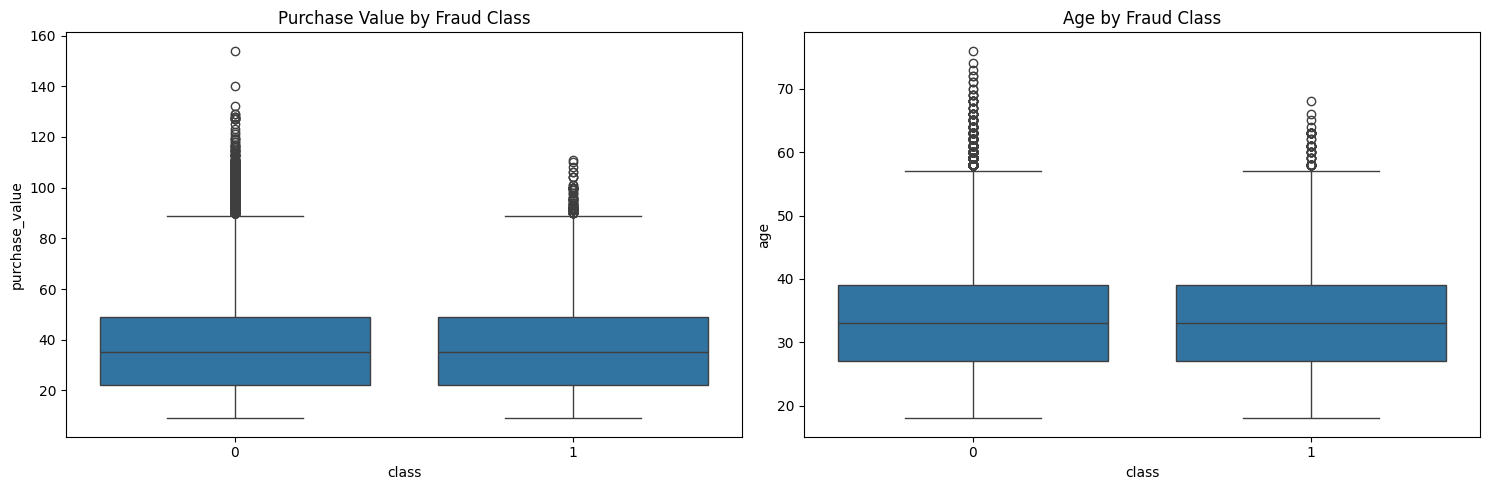

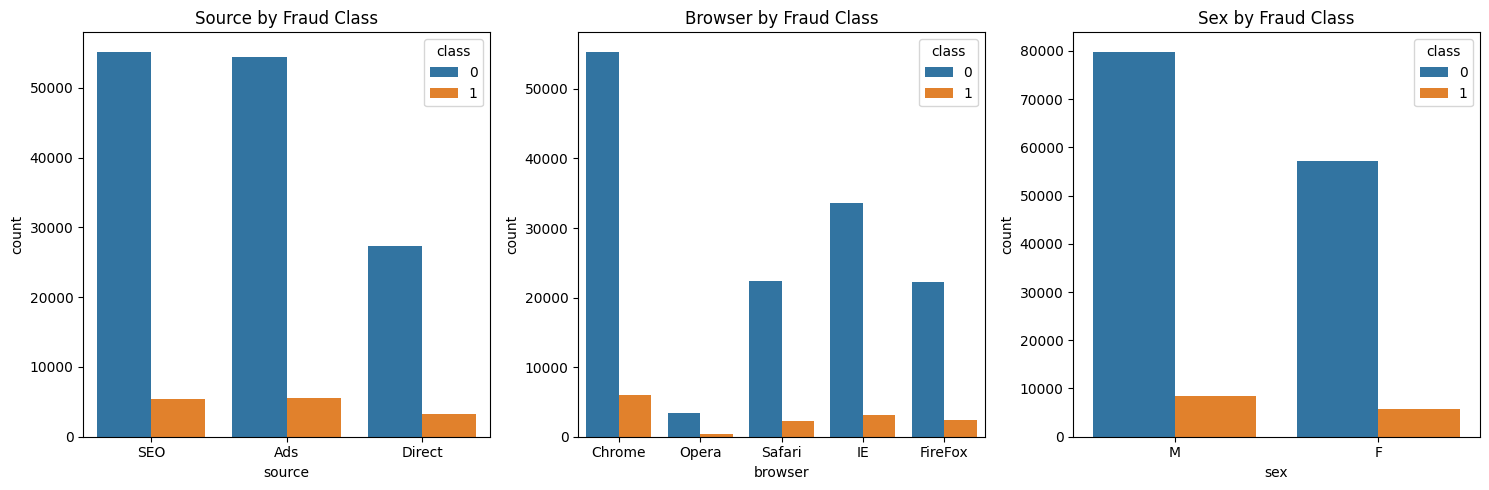

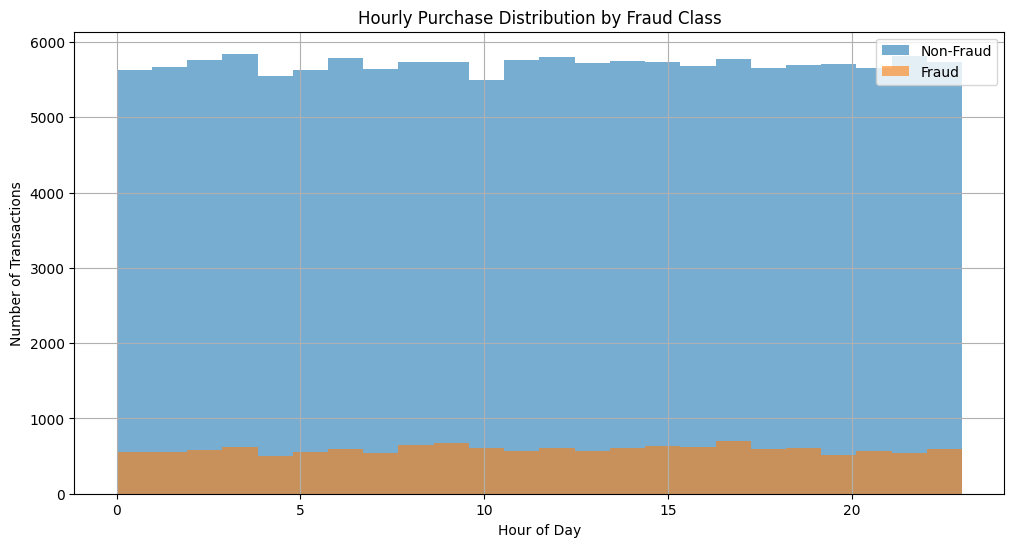

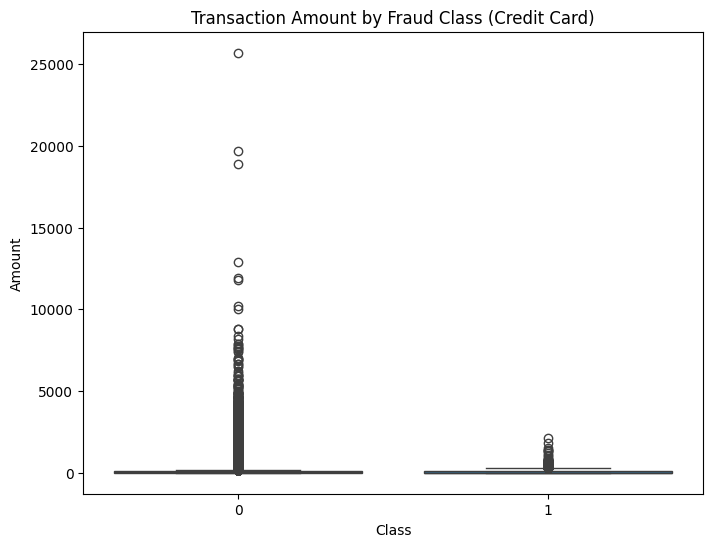

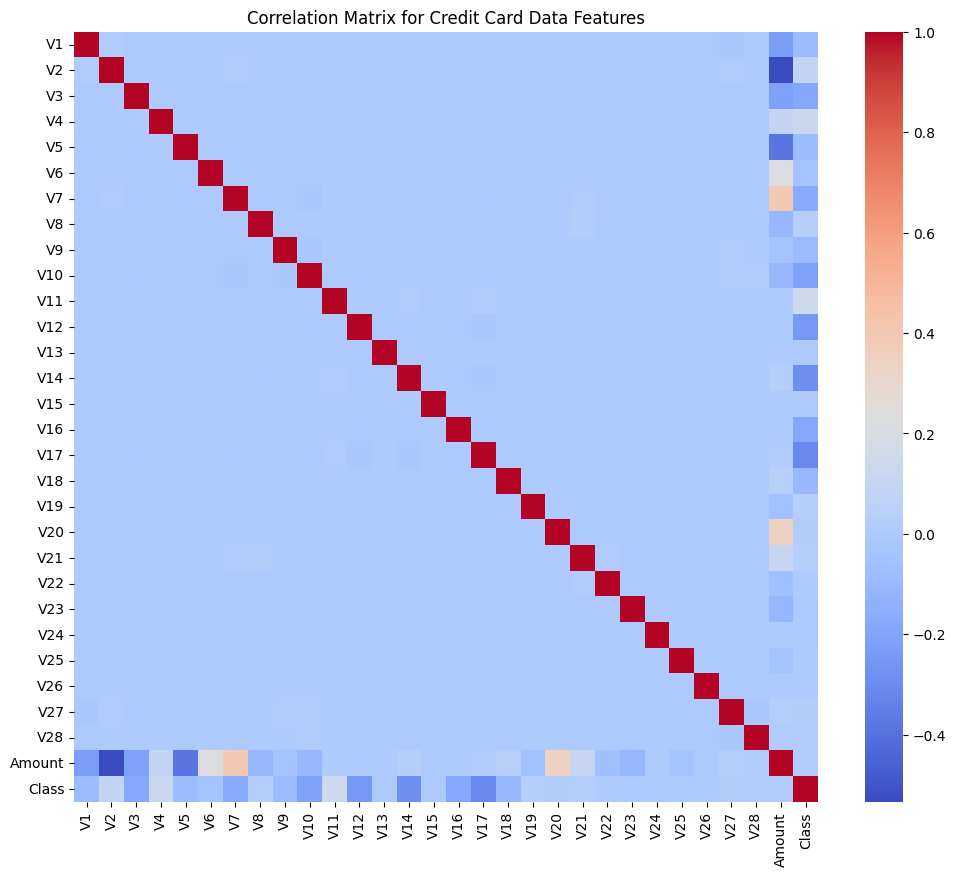

In [7]:
# Fraud_Data: Class vs. numerical features
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='class', y='purchase_value', data=fraud_data)
plt.title('Purchase Value by Fraud Class')

plt.subplot(1, 2, 2)
sns.boxplot(x='class', y='age', data=fraud_data)
plt.title('Age by Fraud Class')
plt.tight_layout()
plt.show()

# Fraud_Data: Class vs. categorical features
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x='source', hue='class', data=fraud_data)
plt.title('Source by Fraud Class')

plt.subplot(1, 3, 2)
sns.countplot(x='browser', hue='class', data=fraud_data)
plt.title('Browser by Fraud Class')

plt.subplot(1, 3, 3)
sns.countplot(x='sex', hue='class', data=fraud_data)
plt.title('Sex by Fraud Class')
plt.tight_layout()
plt.show()

# Time-based analysis for Fraud_Data (after feature engineering, but good to visualize here)
# For now, let's look at purchase time distribution for fraud vs non-fraud
plt.figure(figsize=(12, 6))
fraud_data[fraud_data['class'] == 0]['purchase_time'].dt.hour.hist(bins=24, alpha=0.6, label='Non-Fraud')
fraud_data[fraud_data['class'] == 1]['purchase_time'].dt.hour.hist(bins=24, alpha=0.6, label='Fraud')
plt.title('Hourly Purchase Distribution by Fraud Class')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.legend()
plt.show()

# CreditCard_Data: Class vs. Amount
plt.figure(figsize=(8, 6))
sns.boxplot(x='Class', y='Amount', data=credit_card_data)
plt.title('Transaction Amount by Fraud Class (Credit Card)')
plt.show()

# CreditCard_Data: Correlation matrix for V features and Amount
plt.figure(figsize=(12, 10))
sns.heatmap(credit_card_data.drop('Time', axis=1).corr(), cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Correlation Matrix for Credit Card Data Features')
plt.show()

Merging Fraud_Data with IpAddress_to_Country (this may take a moment)...
Merging complete!

--- Distribution of Countries in Fraud_Data ---
country
United States        58049
Unknown              21966
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Name: count, dtype: int64


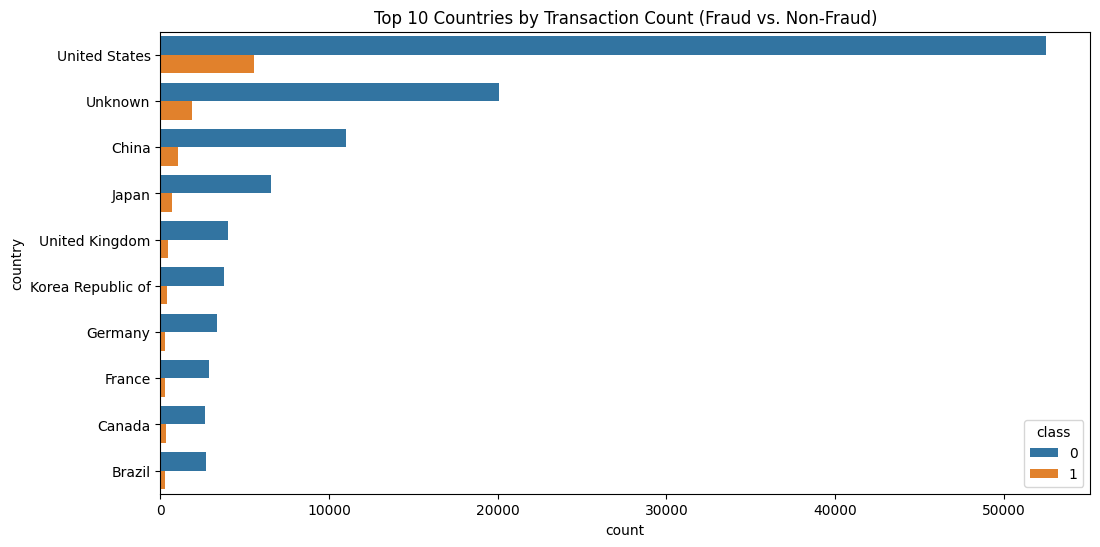

In [ ]:

# Sort ip_to_country by lower_bound_ip_address for efficient searching (e.g., using searchsorted)
ip_to_country_sorted = ip_to_country.sort_values(by='lower_bound_ip_address').reset_index(drop=True)

def get_country(ip_address, ip_ranges_df):
    # Use searchsorted to find the index where ip_address would be inserted
    # This gives us the index of the first lower_bound_ip_address GREATER than ip_address
    idx = ip_ranges_df['lower_bound_ip_address'].searchsorted(ip_address, side='right') - 1

    # Check if the found index is valid and if the IP falls within the range
    if idx >= 0 and ip_address <= ip_ranges_df.loc[idx, 'upper_bound_ip_address']:
        return ip_ranges_df.loc[idx, 'country']
    return 'Unknown' # Or np.nan

print("Merging Fraud_Data with IpAddress_to_Country (this may take a moment)...")
# Apply the function to each IP address in fraud_data
fraud_data['country'] = fraud_data['ip_address'].apply(lambda x: get_country(x, ip_to_country_sorted))
print("Merging complete!")

# Display value counts for the new 'country' column
print("\n--- Distribution of Countries in Fraud_Data ---")
print(fraud_data['country'].value_counts().head(10))

plt.figure(figsize=(12, 6))
sns.countplot(y='country', hue='class', data=fraud_data, order=fraud_data['country'].value_counts().index[:10])
plt.title('Top 10 Countries by Transaction Count (Fraud vs. Non-Fraud)')
plt.show()

In [ ]:
# Sort by user_id and purchase_time
fraud_data = fraud_data.sort_values(by=['user_id', 'purchase_time'])

# Calculate time difference between consecutive transactions for the same user
fraud_data['time_diff_user'] = fraud_data.groupby('user_id')['purchase_time'].diff().dt.total_seconds()

# Calculate time difference between consecutive transactions for the same device
fraud_data = fraud_data.sort_values(by=['device_id', 'purchase_time'])
fraud_data['time_diff_device'] = fraud_data.groupby('device_id')['purchase_time'].diff().dt.total_seconds()

# Feature: Number of transactions per user/device in a time window (e.g., 24 hours)
# This is more complex and typically requires a rolling window or grouping.
# For simplicity, let's start with count of unique transactions per device_id and user_id.

# Count of transactions per device_id
device_transaction_counts = fraud_data.groupby('device_id')['purchase_time'].transform('count')
fraud_data['device_transaction_count'] = device_transaction_counts

# Count of transactions per user_id
user_transaction_counts = fraud_data.groupby('user_id')['purchase_time'].transform('count')
fraud_data['user_transaction_count'] = user_transaction_counts



In [16]:
# Time-Based features for Fraud_Data.csv
# Hour of day
fraud_data['hour_of_day'] = fraud_data['purchase_time'].dt.hour

# Day of week
fraud_data['day_of_week'] = fraud_data['purchase_time'].dt.dayofweek # Monday=0, Sunday=6

# Day of year (useful for seasonal patterns)
fraud_data['day_of_year'] = fraud_data['purchase_time'].dt.dayofyear

# Month of year
fraud_data['month_of_year'] = fraud_data['purchase_time'].dt.month

# time_since_signup: Calculate the duration between signup_time and purchase_time.
fraud_data['time_since_signup_seconds'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds()

In [ ]:
# 7. Data Transformation
print("\n--- Class Imbalance in Fraud_Data ---")
print(fraud_data['class'].value_counts(normalize=True))

print("\n--- Class Imbalance in CreditCard_Data ---")
print(credit_card_data['Class'].value_counts(normalize=True))



--- Class Imbalance in Fraud_Data ---
class
0    0.906354
1    0.093646
Name: proportion, dtype: float64

--- Class Imbalance in CreditCard_Data ---
Class
0    0.998333
1    0.001667
Name: proportion, dtype: float64


In [ ]:
# Identify numerical features for scaling
numerical_features_fraud = [
    'purchase_value', 'age', 'ip_address',
    'time_diff_user', 'time_diff_device',
    'device_transaction_count', 'user_transaction_count',
    'time_since_signup_seconds'
]
# Add time-based features
numerical_features_fraud.extend(['hour_of_day', 'day_of_week', 'day_of_year', 'month_of_year'])

numerical_features_credit = ['Time', 'Amount'] + [f'V{i}' for i in range(1, 29)] # All V features and Time, Amount

# Identify categorical features for encoding
categorical_features_fraud = ['source', 'browser', 'sex', 'country']
